In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading the path to the folder
DATA_PATH = "/content/drive/MyDrive/studia/Inżynierka/MAIN/"

In [33]:
del data

In [4]:
# Loading the prepared dataset
data = pd.read_csv(DATA_PATH + 'PreparedDataset.csv', low_memory=False)
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  3481 non-null   datetime64[ns, UTC]
 1   Close     3481 non-null   float64            
 2   Returns   3481 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 81.7 KB
None


In [5]:
print(data.columns)

Index(['Datetime', 'Close', 'Returns'], dtype='object')


In [6]:
data.head()

,Datetime,Close,Returns
0,2022-12-12 17:30:00+00:00,26.840000,0.22
1,2022-12-12 18:30:00+00:00,26.965000,0.47
2,2022-12-12 19:30:00+00:00,27.200001,0.87
3,2022-12-12 20:30:00+00:00,27.299999,0.37
4,2022-12-13 14:30:00+00:00,27.719999,1.54


In [7]:
train_size = int(len(data) * 0.7)
train_price, test_price = data['Close'][:train_size], data['Close'][train_size:]
train, test = data['Close'][:train_size], data['Close'][train_size:]

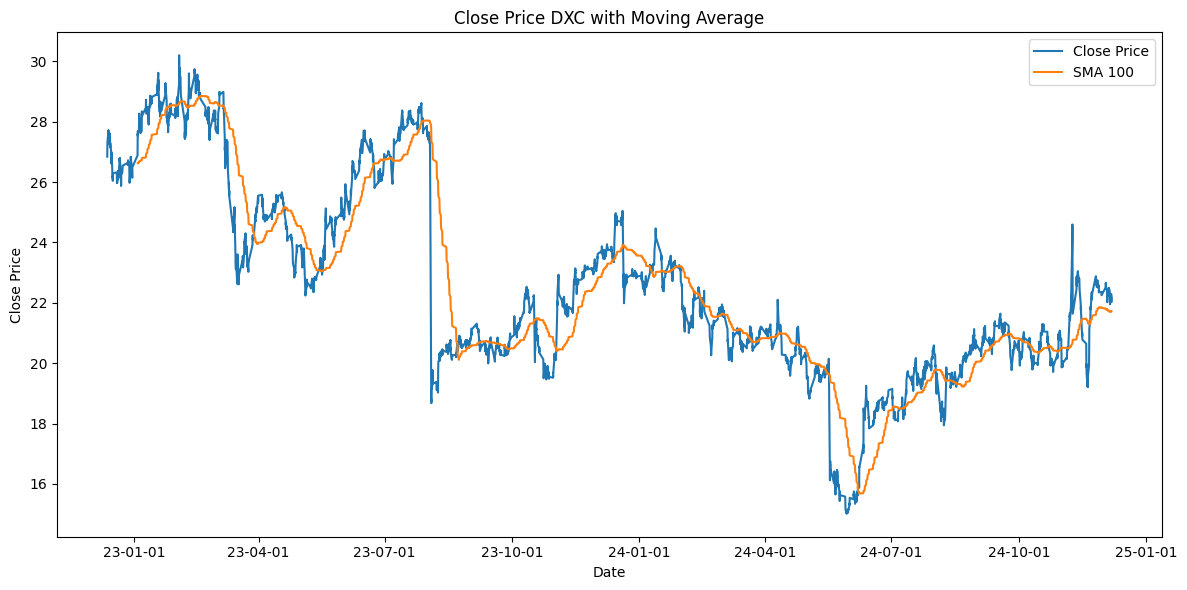

In [38]:
import matplotlib.dates as mdates

sma100 = data.Close.rolling(100).mean()

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.plot(data.Datetime, data.Close, label="Close Price")
ax.plot(data.Datetime, sma100, label="SMA 100")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
plt.title("Close Price DXC with Moving Average")
plt.tight_layout()
plt.legend()
plt.show()

## Checking the Stationarity


In [25]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dicky-Fuller Test:")
dftest = adfuller(data['Close'], autolag='AIC')

output = pd.Series(dftest[0:4], index=['ADF Statistic:','p-value:','Lags:','Number of Observations:'])
for key,value in dftest[4].items():
    output['Critical Value (%s):'%key] = value

print(output)

Results of Dicky-Fuller Test:
ADF Statistic:               -2.373811
p-value:                      0.149265
Lags:                         0.000000
Number of Observations:    3480.000000
Critical Value (1%):         -3.432230
Critical Value (5%):         -2.862371
Critical Value (10%):        -2.567212
dtype: float64


In [22]:
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    dfr = result[0] # Test statistic (ADF value)
    pvalue = result[1] # p-value
    critical_value = result[4]['5%'] # The critical value at the 5% significance level
    if (pvalue <= 0.05) and (dfr < critical_value):
      return True # STATIONARY
    else:
      return False # NON-STATIONARY

# Check if timeseries is stationary
stationarity = check_stationarity(data['Close'])
print(f"Stationarity of the original dataset is: {stationarity}")

# Explore and Differentiate until timeseries is stationary
d = 0
max_iterations = 10
while not stationarity and d < max_iterations:
    d = d + 1
    data.loc[:,'Close'] = data['Close'].diff(periods=d).dropna()
    stationarity = check_stationarity(data['Close'].dropna())

print(f"Optimal value of d: {d}")

Stationarity of the original dataset is: False
Optimal value of d: 1


## Finding the ARIMA terms

We use tools like ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) to determine the values of p and q. The number of lags where ACF cuts off is q, and where PACF cuts off is p.

In [26]:
data.head()

,Datetime,Close,Returns
0,2022-12-12 17:30:00+00:00,26.840000,0.22
1,2022-12-12 18:30:00+00:00,26.965000,0.47
2,2022-12-12 19:30:00+00:00,27.200001,0.87
3,2022-12-12 20:30:00+00:00,27.299999,0.37
4,2022-12-13 14:30:00+00:00,27.719999,1.54


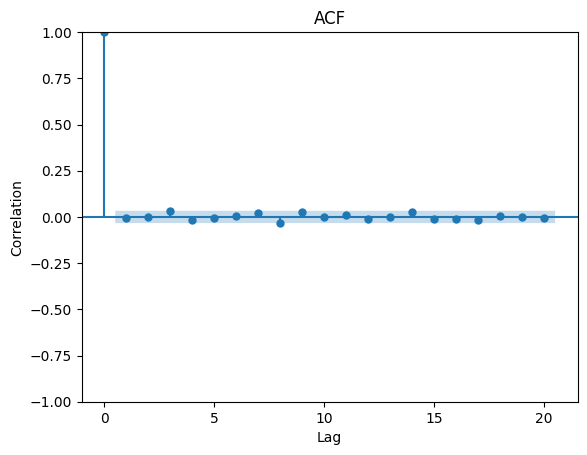

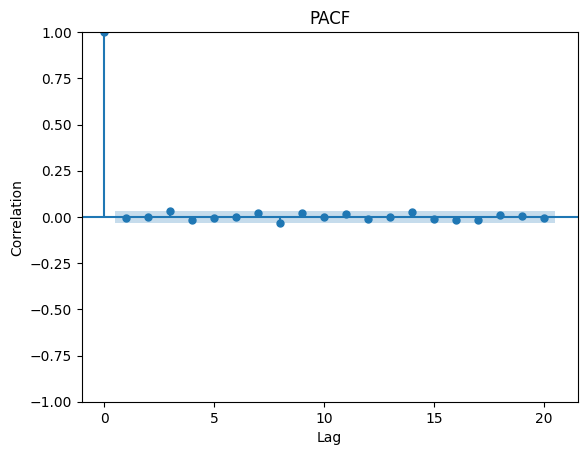

In [27]:
# Plot ACF for returns values (q value)
plot_acf(data['Returns'].dropna(), title='ACF', lags=20)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Plot PACF for returns values (p value)
plot_pacf(data['Returns'].dropna(), title='PACF',lags=20)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

According to our assumptions we define the value of p for '1' and q for '0'.

## Model Diagnostic

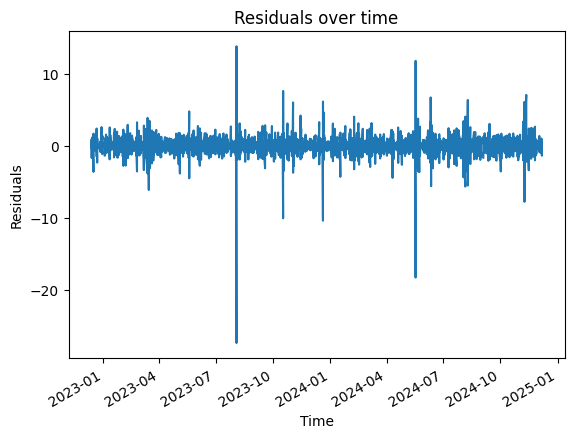

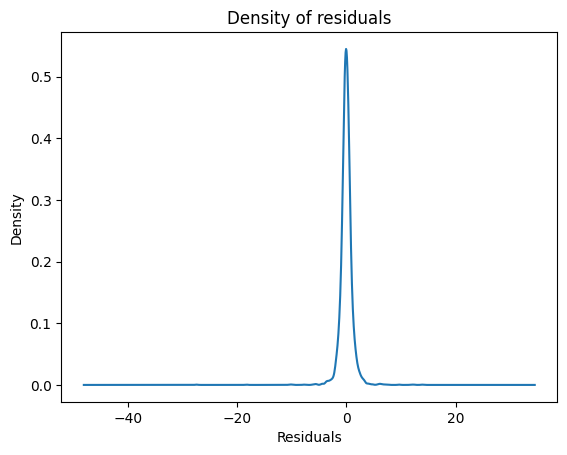

In [11]:
# Checking if the residuals act like white noise- that provides no patterns and no trends
residuals = model_fit.resid
residuals.plot()
plt.title('Residuals over time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('Density of residuals')
plt.xlabel('Residuals')
plt.show()

Based on the visualizations the residuals lack any predictable structure or bias.

In [10]:
# Fit ARIMA (p=1, d=1, q=0)
p, d, q = 1, 1, 0
model = ARIMA(data['Returns'], order = (p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3481
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5678.026
Date:                Fri, 13 Dec 2024   AIC                          11360.052
Time:                        18:33:56   BIC                          11372.362
Sample:                             0   HQIC                         11364.447
                               - 3481                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5034      0.002   -204.436      0.000      -0.508      -0.499
sigma2         1.5300      0.005    292.926      0.000       1.520       1.540
Ljung-Box (L1) (Q):                 112.18   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Fit ARIMA (p=5, d=1, q=0)
p, d, q = 5,1,0
model = ARIMA(data['Returns'], order = (p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
print(model_summary)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3481
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5237.046
Date:                Fri, 13 Dec 2024   AIC                          10486.092
Time:                        18:36:23   BIC                          10523.021
Sample:                             0   HQIC                         10499.275
                               - 3481                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8379      0.006   -135.563      0.000      -0.850      -0.826
ar.L2         -0.6693      0.009    -75.373      0.000      -0.687      -0.652
ar.L3         -0.4725      0.009    -53.200      0.0

## Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

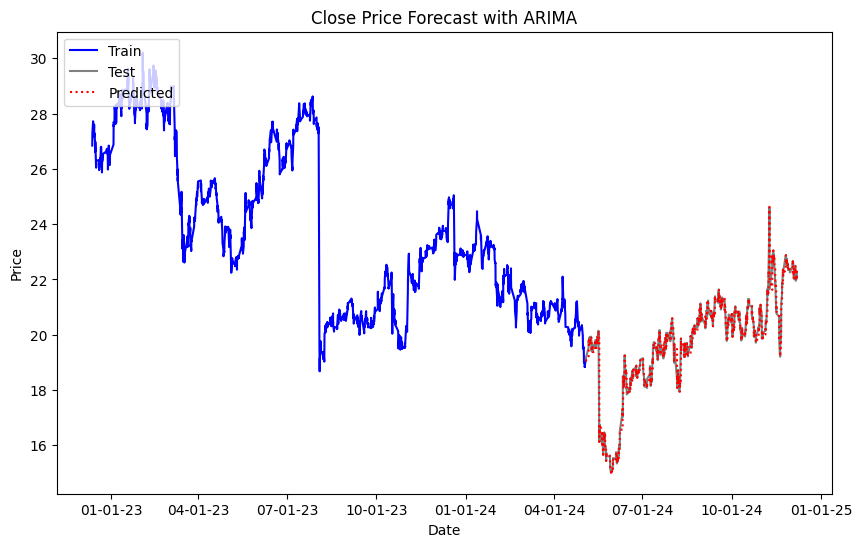

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# ARIMA parameters
p, d, q = 5,1,0

history = [x for x in train]
model_predictions = []

# Performing the rolling forecast for each test point
for tp in range(len(test)):
    # Fitting ARIMA MODEL on current history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Forecasting the next value and update predictions
    forecast = model_fit.forecast()
    model_predictions.append(forecast[0])

    # Updating the history with the actual value (for true rolling forecast)
    history.append(test_price.iloc[tp])

# Converting model predictions to price levels
predicted_prices = pd.Series(model_predictions, index=test_price.index)

data = data.set_index('Datetime')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data.index[:train_size], train_price, color="blue", label="Train")
plt.plot(data.index[train_size:], test_price, color="grey", label="Test")
plt.plot(data.index[train_size:], predicted_prices, label="Predicted", color='red', linestyle=':')
ax=plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
plt.legend(loc='upper left')
plt.title("Close Price Forecast with ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

print(f'p: {p}, d: {d}, q: {q}')

mse =round(mean_squared_error(test_price, predicted_prices), 2)
rmse =round(np.sqrt(mse),2)
mape =round(np.mean(np.abs((test_price-predicted_prices)/test_price))*100, 2)
mae =round(np.mean(np.abs(test_price -predicted_prices)),2)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:',rmse)
print('Mean Absolute Percentage Error:',mape)
print('Mean Absolute Error:', mae)

In [13]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00


## Looking for the best order of parameters for the ARIMA MODEL

In [14]:
from pmdarima import auto_arima

# Using auto_arima to find the best parameters
stepwise_fit = auto_arima(train_price, start_p=1, start_q=1, max_p=5, max_q=5, m=20,
                          seasonal=False, d=1, trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)
print(stepwise_fit.summary())


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (20) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36.915, Time=4.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.400, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.346, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35.350, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.815, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.600 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2436
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -14.908
Date:                Fri, 13 Dec 2024   AIC                             31.815
Time:                        18:50:11   BIC                             37.613
Sample:                             0   HQIC                            33.923
                               - 2436                                         
Covaria